<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
This notebook is designed specially for the module

ET5003 - MACHINE LEARNING APPLICATIONS 

Instructor: Enrique Naredo
###ET5003_NNwithFixedLayers

© All rights reserved to the author, do not share outside this module.


## Introduction

[Artificial neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network) (ANNs), usually simply called neural networks ( [NNs](https://www.investopedia.com/terms/n/neuralnetwork.asp)), are computing systems inspired by the biological neural networks that constitute animal brains.

* An ANN is based on a collection of connected units or nodes called artificial neurons, which loosely model the neurons in a biological brain. 
* Each connection, like the synapses in a biological brain, can transmit a signal to other neurons. 
* An artificial neuron receives a signal then processes it and can signal neurons connected to it. 
* The "signal" at a connection is a real number, and the output of each neuron is computed by some non-linear function of the sum of its inputs. 
* The connections are called edges. Neurons and edges typically have a weight that adjusts as learning proceeds. 
* The weight increases or decreases the strength of the signal at a connection. 
* Neurons may have a threshold such that a signal is sent only if the aggregate signal crosses that threshold. 
* Typically, neurons are aggregated into layers. Different layers may perform different transformations on their inputs. 
* Signals travel from the first layer (the input layer), to the last layer (the output layer), possibly after traversing the layers multiple times.

**Acknowledgement**

This notebook is refurbished taking source code from Alessio Benavoli's webpage and from the libraries numpy, GPy, pylab, and pymc3.

## Libraries

In [ ]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# https://pypi.org/project/GPy/
!pip install gpy

In [ ]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm
%matplotlib inline

## Data generation
Generate data from a nonlinear function and use a Gaussian Process to sample it.

In [ ]:
# seed the legacy random number generator
# to replicate experiments
seed = None
#seed = 7
np.random.seed(seed)

In [ ]:
# training set
# points evenly spaced over [0,1]
samples_train = 500
X_train = np.linspace(-1,1,samples_train) 

# min-max training
X_train.min(), X_train.max()

(-1.0, 1.0)

In [ ]:
# test set
# points evenly spaced over [0,1]
samples_test = 200
X_test = np.linspace(-1,1,samples_test)

# min-max training
X_test.min(), X_test.max()

(-1.0, 1.0)

In [ ]:
# Gather all samples to get a model from them
# Stack arrays in sequence horizontally (column wise)
X_all = np.hstack([X_train,X_test]).reshape(-1,1)

In [ ]:
# mean μ=0: distribution centered at zero
μ = np.zeros(samples_train + samples_test)
print(μ.shape)

(700,)


In [ ]:
# Gaussian Processes
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
# Radial Basis Functions
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
# kernel is a function that specifies the degree of similarity 
# between variables given their relative positions in parameter space
kernel = GPy.kern.RBF(input_dim=1,lengthscale=0.15,variance=0.2)
print(kernel)

  rbf.         |  value  |  constraints  |  priors
  variance     |    0.2  |      +ve      |        
  lengthscale  |   0.15  |      +ve      |        


In [ ]:
# covariance matrix
C = kernel.K(X_all,X_all)
print(C.shape)

(700, 700)


In [ ]:
# Generate samples using μ & C parameters

# random generator using normal distribution
# mean=μ, cov=C, size=1
# true function
TF = np.random.multivariate_normal(μ,C,1)[0,:]

# noise factor
noise = 0.1

# training noisy data -> 0.1 (10%)
y_train = TF[0:samples_train] + np.random.randn(samples_train)*noise

# test noisy data -> 0.1 (10%)
y_test = TF[samples_train:] + np.random.randn(samples_test)*noise

# TF-> true function
TF = TF[samples_train:]

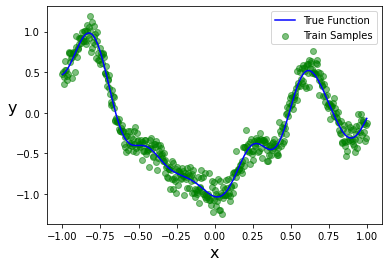

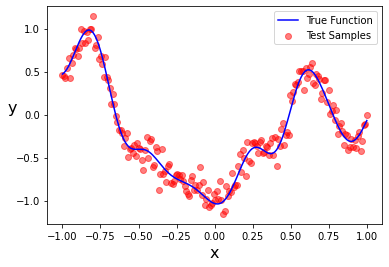

In [ ]:
# Plotting using pylab (pb)

# 1) First figure
pb.figure()
# the default drawing order for axes is patches, lines, text
# this order is determined by the zorder attribute
pb.plot(X_test,TF,zorder=100,c='b',label='True Function')
# train: scatter plot
pb.scatter(X_train,y_train,c='g',label='Train Samples',alpha=0.5)
pb.legend()
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16,rotation=0)
# save temporarily to drive
pb.savefig("Gaussian_train_1.pdf")

# 2) Second figure
pb.figure()
pb.plot(X_test,TF,zorder=100,c='b',label='True Function')
# test: scatter plot
pb.scatter(X_test,y_test,c='r',label='Test Samples',alpha=0.5)
pb.legend()
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16,rotation=0)
# save temporarily to drive
pb.savefig("Gaussian_test_1.pdf")

## Neural Network

[Mulilayer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (MLP)


**Neural Network with fixed weights in the inner layer**
* We do not need to fit the weights of the inner layer. 
* We can consider the inner layer as a set of basis functions.
* Address the fitting problem as in the Least Squares (LS) algorithm.

In [ ]:
def computeL(X,W):
    """
    Compute L matrix for a single-layer NN
    as in linear regression
    X is the set of samples
    W is a matrix of weights 
    Return the matrix L
    """

    # activation function
    # compute hyperbolic tangent element-wise
    def ϕ(x,w):
        return np.tanh( w[:,0] + x*w[:,1] ) 

    L = []
    # loop to create matrix L
    for i in range(len(X)):
        L.append(ϕ(X[i],W))

    # create a numpy array 
    L = np.array(L)
    
    # column with ones
    O = np.ones((L.shape[0],1))
    # add a column with ones to L
    L = np.hstack([O,L])

    # return the L matrix
    return L

In [ ]:
def leastsquares(X,y):
    """
    Computes the Least Squares (LS) method
    https://en.wikipedia.org/wiki/Least_squares
    """
    # machine epsilon 
    # https://en.wikipedia.org/wiki/Machine_epsilon
    # for float values can be obtained by typing
    eps = np.finfo(float).eps

    # we add this epsilon to avoid numerical problems when we invert the matrix
    # linalg-> linear algebra functions
    M = np.linalg.inv(np.matmul(X.T,X) + eps*np.identity(X.shape[1]))

    # matmul-> matrix product of two arrays
    # X.T-> transposed array
    # https://numpy.org/doc/stable/reference/generated/numpy.ndarray.T.html#numpy.ndarray.T
    theta = np.matmul(M, np.matmul(X.T,y) )
    return theta

In [ ]:
# hu-> hidden units
hu = 10

In [ ]:
# generate random weights for 2 inner layers
W = np.random.randn(hu,2) 
print(W)

[[ 1.5532174   0.37135194]
 [-0.26007011  0.78649993]
 [-0.66542411 -0.30258992]
 [ 0.71358741 -0.33239521]
 [ 0.0745689   0.37304242]
 [ 3.24839041  0.93175508]
 [-0.50617125 -1.52160443]
 [ 1.23084752  0.84154803]
 [-0.30253608  0.2856251 ]
 [ 0.41521627  0.8479533 ]]


In [ ]:
# train: compute H matrix as in linear regression
MLP_train = computeL(X_train,W)
print(MLP_train)

[[ 1.          0.82803893 -0.78046928 ...  0.37075617 -0.52857182
  -0.40760614]
 [ 1.          0.82850622 -0.77923411 ...  0.37366182 -0.52774637
  -0.40476827]
 [ 1.          0.82897237 -0.77799286 ...  0.37656016 -0.52691992
  -0.40192257]
 ...
 [ 1.          0.95804832  0.47779664 ...  0.96838383 -0.0191982
   0.85006091]
 [ 1.          0.95817041  0.48022564 ...  0.96859305 -0.0180538
   0.85100095]
 [ 1.          0.95829215  0.4826473  ...  0.96880091 -0.01690936
   0.85193558]]


In [ ]:
# array shapes
X_train.shape, W.shape, MLP_train.shape

((500,), (10, 2), (500, 11))

In [ ]:
# estimate weights θ for the outer layer (linear layer)
θ_ol = leastsquares(MLP_train,y_train)
print(θ_ol)

[ 4.73645734e+05 -2.06637397e+06 -5.93807734e+04 -1.59282644e+06
 -1.98867650e+06  1.53066384e+06  5.51557586e+05 -1.15612477e+03
 -1.05666264e+05 -3.94956781e+06 -1.08226834e+05]


In [ ]:
# test: compute H matrix as in linear regression
MLP_test = computeL(X_test,W)

In [ ]:
# predictions
y_pred = np.matmul(MLP_test,θ_ol)
print(y_pred)

[-0.34233662 -0.04947071  0.19059869  0.38425963  0.53734608  0.65516747
  0.74253798  0.80380536  0.84287923  0.86325889  0.86806056  0.86004387
  0.84163776  0.81496555  0.78186928  0.74393316  0.70250621  0.65872394
  0.61352908  0.56769145  0.5218267   0.47641417  0.43181364  0.3882811
  0.34598351  0.30501244  0.26539678  0.22711436  0.19010258  0.15426809
  0.11949543  0.08565474  0.05260864  0.02021808 -0.0116525  -0.04313099
 -0.07433403 -0.10536427 -0.13630824 -0.16723491 -0.19819475 -0.22921941
 -0.26032177 -0.29149652 -0.32272103 -0.35395657 -0.38514985 -0.41623463
 -0.44713372 -0.47776087 -0.50802293 -0.53782193 -0.56705723 -0.59562754
 -0.623433   -0.65037701 -0.67636806 -0.70132131 -0.7251601  -0.74781712
 -0.76923556 -0.78936991 -0.80818663 -0.82566456 -0.84179512 -0.85658235
 -0.87004265 -0.88220445 -0.89310757 -0.90280256 -0.91134972 -0.91881815
 -0.92528459 -0.9308322  -0.93554923 -0.9395277  -0.94286204 -0.9456476
 -0.94797937 -0.94995056 -0.95165129 -0.95316735 -0.9

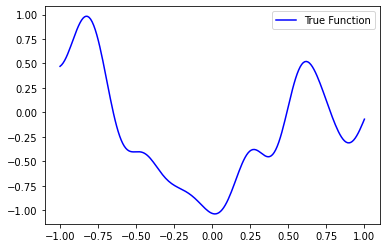

In [ ]:
# plot test data with TF -> true function
pb.plot(X_test,TF,c='blue',label='True Function')
pb.legend()

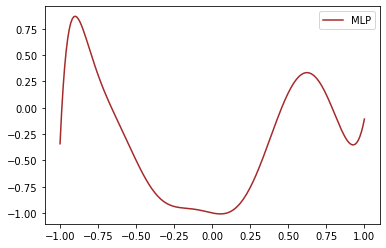

In [ ]:
# plot test data with predictions
pb.plot(X_test,y_pred,c='brown',label='MLP')
pb.legend()

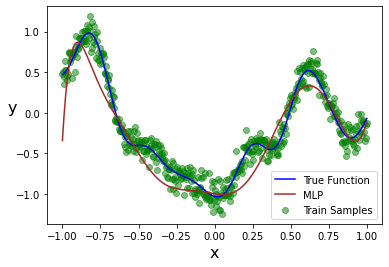

In [ ]:
# plot all together
pb.plot(X_test,TF,c='b',label='True Function')
pb.plot(X_test,y_pred,c='brown',label='MLP')
pb.scatter(X_train,y_train,c='g',label='Train Samples',alpha=0.5)
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16,rotation=0)
pb.legend()

# save temporarily to drive
pb.savefig("MLP_pred_1.pdf") 

### Plot of the basis functions

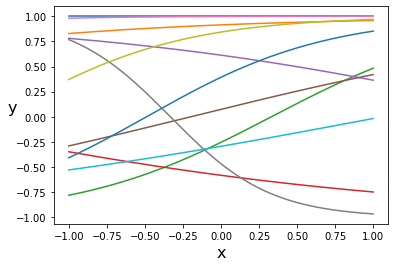

In [ ]:
# Basis functions 
# https://www.psych.mcgill.ca/misc/fda/ex-basis-a1.html
pb.plot(X_train,MLP_train)
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16,rotation=0)
pb.savefig("Basis_functions_1.pdf")


## Fitting the inner layer too


**The above approach works.**

But, if we also optimize the weights of the inner layer, then we can have a better estimate by using less hidden units.

* This is what [Keras](https://keras.io/) does.
* We have the usual over-fitting problem for general-recipe ML algorithms. 
* Increasing the hidden units and therefore the network parameters, the NN starts overfitting!

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

An [epoch](https://radiopaedia.org/articles/epoch-machine-learning) is a term used in machine learning and indicates the number of passes of the entire training dataset the machine learning algorithm has completed. 
* Datasets are usually grouped into batches (especially when the amount of data is very large). 
* Some people use the term iteration loosely and refer to putting one batch through the model as an iteration.   

In [ ]:
# start with 250 epochs, then increase them to 25000 or more?
num_epochs = 250

[Batch size](https://radiopaedia.org/articles/batch-size-machine-learning) is a term used in machine learning and refers to the number of training examples utilized in one iteration. 

The batch size can be one of three options:

* batch mode: where the batch size is equal to the total dataset thus making the iteration and epoch values equivalent

* mini-batch mode: where the batch size is greater than one but less than the total dataset size. Usually, a number that can be divided into the total dataset size.

* stochastic mode: where the batch size is equal to one. Therefore the gradient and the neural network parameters are updated after each sample.



In [ ]:
# batch size
batch_size = 200

In [ ]:
# fix random seed for reproducibility
seed = None
#seed = 7
np.random.seed(seed)

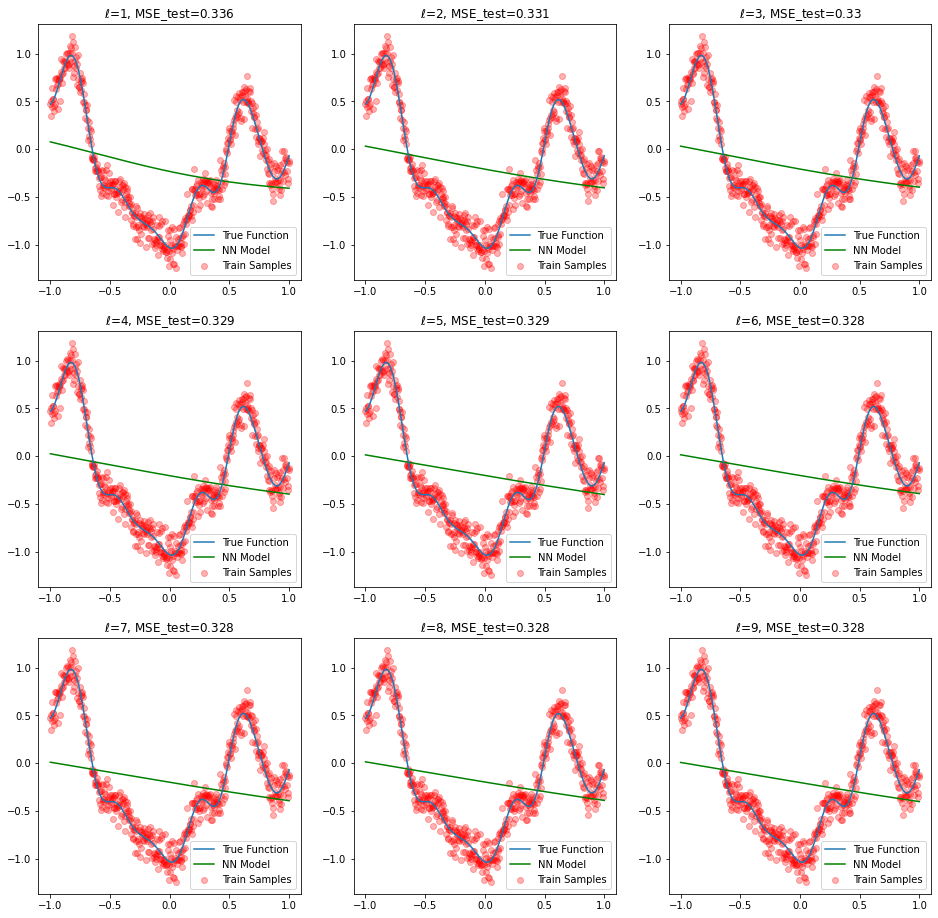

In [ ]:
# figure with subplots (9)
fig, axs = pb.subplots(3,3, figsize=(16, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# ravel-> return a contiguous flattened array
# https://numpy.org/doc/stable/reference/generated/numpy.ravel.html
axs = axs.ravel()

# first index
ax_index = 0

# loop in the hidden units
for i in range(1,10,1):   

    # Sequential-> groups a linear stack of layers into a tf.keras.Model
    model = Sequential()

    # inner layer
    # Dense implements the operation: output = activation(dot(input, kernel) + bias)
    model.add(Dense(i, input_dim=1, kernel_initializer='normal', activation='tanh', name='input_layer'))

    # outer linear layer
    model.add(Dense(1, kernel_initializer='normal', activation='linear', name='output_layer'))

    # compile model
    # configure the model for training
    # mse = tf.keras.losses.MeanSquaredError()
    # https://keras.io/api/losses/regression_losses/#mean_squared_error-function
    # adam-> optimizer, https://keras.io/api/optimizers/
    model.compile(loss='mse', optimizer='adam')

    # fit model: train the model for a fixed number of epochs
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=0)

    # predictions
    y_pred2 = model.predict(X_test)

    # MSE-> Mean Squared Error in test set
    MSE_test = np.round( np.mean( (y_pred2 - y_test)**2 ), 3)

    # plots
    axs[ax_index].plot(X_test,TF,zorder=100,label='True Function')
    axs[ax_index].plot(X_test,y_pred2,c='green',label='NN Model')
    axs[ax_index].scatter(X_train,y_train,c='r',label='Train Samples',alpha=0.3)
    axs[ax_index].set_title('$\ell$='+str(i)+', MSE_test='+str(MSE_test) )
    axs[ax_index].legend()

    # index counter
    ax_index = ax_index+1

# save temporarily to drive
pb.savefig("NN_overfitting.pdf", bbox_inches='tight')

Here you have some examples of how to compute MSE, following these ideas, you could build your own methods or to write your code in different way.

In [ ]:
# examples to compute MSE
y_1 = [3, -0.5, 2, 7]
y_1 = np.array(y_1)
y_2 = [2.5, 0.0, 2, 8]
y_2 = np.array(y_2)

# 1) using sklearn
from sklearn.metrics import mean_squared_error
MSE_sklearn = mean_squared_error(y_1, y_2)
print(MSE_sklearn)

# 2) numpy custom-1
MSE_custom1 = np.round( np.mean( (y_1 - y_2)**2 ), 3)
print(MSE_custom1)

# 3) numpy custom-2
MSE_custom2 = np.square(np.subtract(y_1, y_2)).mean()
print(MSE_custom2)

0.375
0.375
0.375


## New data

In [ ]:
# number of samples
num_samples_train = 250 
num_samples_test = 200

# intervals to sample
a, b, c = 0.2, 0.6, 0.8
# points evenly spaced over [0,1]
interval_1 = np.random.rand(int(num_samples_train/2))*b - c
interval_2 = np.random.rand(int(num_samples_train/2))*b + c

X_new_train = np.sort(np.hstack([interval_1,interval_2])) 
X_new_test  = np.linspace(-1,1,num_samples_test)

X_new_all = np.hstack([X_new_train,X_new_test]).reshape(-1,1)

# vector of the means
μ_new = np.zeros((len(X_new_all)))
# covariance matrix
C_new = kernel.K(X_new_all,X_new_all)

# noise factor
noise_new = 0.1

# generate samples path with mean μ and covariance C
TF_new = np.random.multivariate_normal(μ_new,C_new,1)[0,:]
y_new_train = TF_new[0:len(X_new_train)] + np.random.randn(len(X_new_train))*noise_new
y_new_test = TF_new[len(X_new_train):] + np.random.randn(len(X_new_test))*noise_new
TF_new = TF_new[len(X_new_train):]

In this example, first generate a nonlinear functions and then generate noisy training data from that function.

The constrains are:
* Training samples $x$ belong to either interval $[-0.8,-0.2]$ or $[0.2,0.8]$.
* There is not data training samples from the interval $[-0.2,0.2]$. 
* The goal is to evaluate the extrapolation error outside in the interval  $[-0.2,0.2]$.

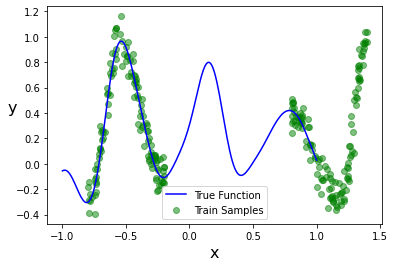

In [ ]:
# plot 
pb.figure()
pb.plot(X_new_test,TF_new,c='b',label='True Function',zorder=100)
# training data
pb.scatter(X_new_train,y_new_train,c='g',label='Train Samples',alpha=0.5)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.legend()
pb.savefig("New_data.pdf")

In [ ]:
model_new = Sequential()
epochs_new = 20
# inner layer
model_new.add(Dense(epochs_new, input_dim=1, kernel_initializer='normal', activation='tanh', name='input_layer'))
# outer linear layer
model_new.add(Dense(1, kernel_initializer='normal', activation='linear', name='output_layer'))

# Create a model
model_new.compile(loss='mse',  optimizer='adam')

# fit model
model_new.fit(X_new_train, y_new_train, epochs=250, batch_size=20, verbose=0)
#model_new.fit(X_new_train, y_new_train, epochs=25000, batch_size=200, verbose=0)

Note that **general-recipe ML** does not tell anything about the uncertainty. 

* For instance, the estimation 
in $[-0.2,0.2]$ should be less reliable than that in $[-0.8,-0.2]$ because there is no data in  $[-0.2,0.2]$.

* However, Keras only returns the prediction, there is no uncertainty.

* This together with the overfitting problems shows once again that general-recipe ML is not a sound approach.

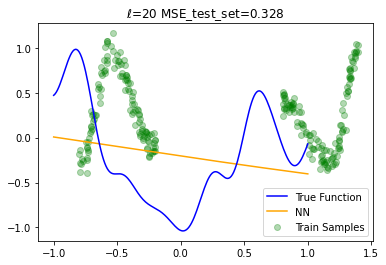

In [ ]:
# plot
y_new_pred = model.predict(X_new_test)
pb.plot(X_new_test,TF,zorder=100,c='b',label='True Function')
pb.scatter(X_new_train, y_new_train,c='green',label='Train Samples',alpha=0.3)
pb.plot(X_new_test,y_new_pred,c='orange',label='NN')
pb.title('$\ell$='+str(epochs_new)+' MSE_test_set='+str(np.round(np.mean((y_new_pred - y_new_test)**2),3)))
pb.legend()
pb.savefig("NN_gap.pdf",  bbox_inches='tight')